# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

<div class="alert alert-block alert-success" style="color:black;">
<b>To Begin:</b> Use this <b>TreasureHuntGame_starterCode.ipynb</b> file to complete your assignment. 
<br><br>
You have been provided with two Python classes and this notebook to help you with this assignment. The first class, <b>TreasureMaze.py</b>, represents the environment, which includes a maze object defined as a matrix. The second class, <b>GameExperience.py</b>, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation in the qtrain() function for which a skeleton implementation has been provided. 
</div>
<br>
<div class="alert alert-block alert-info" style="color:black;">
<b>NOTE: </b>The code block you will need to complete will have <b>#TODO</b> as a header.
<br> First, read and review the next few code and instruction blocks to understand the code that you have been given.</div>

<div class="alert alert-block alert-warning" style="color: #333333;">
<b>Installations</b> The following command will install the necessary Python libraries to necessary to run this application. If you see a "[notice] A new release of pip is available: 23.1.2 -> 25.2" at the end of the installation, you may disregard that statement. 
</div>

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 24.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


<h2>Tensorflow CPU Acceleration Warning</h2>
<div class="alert alert-block alert-danger" style="color: #333333;">
<b>GPU/CUDA/Memory Warnings/Errors:</b> You may receive some errors referencing that GPUs will not be used, CUDA could not be found, or free system memory allocation errors. These and a few others, are standard errors that can be ignored here as they are environment based.<br><br>
    <b>Example messages:</b>
    <ul>
        <li>oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders</li>
        <li>WARNING: All log messages before absl::InitializeLog() is called are written to STDERR</li>
</div>

In [2]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import clone_model
from keras.models import Sequential
from keras.layers import Dense, Activation, PReLU
from keras.optimizers import SGD , Adam, RMSprop
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience

import tensorflow as tf
# Force TensorFlow to use CPU only
tf.config.set_visible_devices([], 'GPU')

%matplotlib inline

I0000 00:00:1765490865.032198     366 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1765490865.730323     366 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1765490865.735418     366 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


<h2> Maze Object Generation</h2>

<div class="alert alert-block alert-info" style="color:black;">
    <b>NOTE:</b>  The following code block contains an 8x8 matrix that will be used as a maze object:
</div>

In [3]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

<h2>Helper Functions and Global Variables</h2>

<div class="alert alert-block alert-info" style="color:black;">
This <b>show()</b> helper function allows a visual representation of the maze object:
</div>

In [4]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The <b>pirate agent</b> can move in four directions: left, right, up, and down. 

<div class="alert alert-block alert-warning" style="color:black;">
<b>Note:</b> While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is the <b>EXPLORATION</b> values from the Cartpole assignment. The hyperparameters are provided here and used in the <b>qtrain()</b> method. 
You are encouraged to try various values for the exploration factor and see how the algorithm performs.
</div>

In [5]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.5
epsilon_min = 0.05
epsilon_decay = 0.995
patience = 10

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


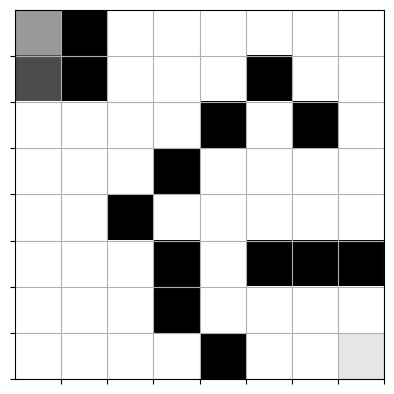

In [6]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

<div class="alert alert-block alert-warning" style="color:black;">
    <b>NOTE:</b> This <b>play_game()</b> function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object, the starting position of the pirate and max amount of steps to make sure the code does not get stuck in a loop.
</div>

In [7]:
def play_game(model, qmaze, pirate_cell, max_steps=None):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    steps = 0
    if max_steps is None:
        max_steps = qmaze.maze.size * 4  # safety cutoff

    while steps < max_steps:
        state = np.asarray(envstate, dtype=np.float32)
        if state.ndim == 1:
            state = np.expand_dims(state, axis=0)

        q_values = model(state, training=False).numpy()
        action = np.argmax(q_values[0])

        envstate, reward, game_status = qmaze.act(action)
        steps += 1

        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

    return False  # timed out with no result

<div class="alert alert-block alert-warning" style="color:black;">
<b>Note: </b>
    This <b>completion_check()</b> function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.
</div>

In [8]:
def completion_check(model, maze_or_qmaze, max_steps=None):
    # Accept either raw numpy maze or TreasureMaze instance
    if isinstance(maze_or_qmaze, TreasureMaze):
        qmaze = maze_or_qmaze
    else:
        qmaze = TreasureMaze(maze_or_qmaze)

    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            continue
        if not play_game(model, qmaze, cell, max_steps=max_steps):
            return False
    return True

<div class="alert alert-block alert-warning" style="color:black;">
<b>Note: </b>
</b>The <b>build_model()</b> function in the block below will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.
</div>

In [9]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

<div class="alert alert-block alert-warning" style="color:black;">
    <b>Note:</b>
    This <b>train_step()</b> helper function in the block below is used to help predict Q-values (quality values) in the current modelto see how good each action is in a given state and improve the Q-network by reducing the gap between what is predicted and what should have been predicted. 
</div>
<br>
<div class="alert alert-block alert-info" style="color:black;">
If you're interested in reading up on the <i>@tf.function</i>, which is a decorator for Tensorflow to run this code into a TensorFlow computation graph, please refer to this link: <a href="https://www.tensorflow.org/guide/intro_to_graphs">https://www.tensorflow.org/guide/intro_to_graphs</a>
</div>


<h2>Tensorflow GPU Warning</h2>
<div class="alert alert-block alert-danger" style="color: #333333;">
    You will see a <b>warning in red</b> "INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.". This is simply coming from <b>Tensorflow skipping using GPU for this assignment.</b>  
</div>

In [10]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        q_values = model(x, training=True)
        loss = loss_fn(y, q_values)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# #TODO: Complete the Q-Training Algorithm Code Block

<div class="alert alert-block alert-info" style="color:black;">
    This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.
</div>
    <b>Pseudocode:</b>
    <br>
    For each epoch:
        Reset the environment at a random starting cell
        agent_cell = randomly select a free cell
        <br>
        <b>Hint:</b> Review the reset method in the TreasureMaze.py class.
    
        Set the initial environment state
        env_state should reference the environment's current state
        Hint: Review the observe method in the TreasureMaze.py class.

        While game status is not game over:
           previous_envstate = env_state
            Decide on an action:
                - If possible, take a random valid exploration action and 
                  randomly choose action (left, right, up, down)
                  and assign it to an action variable
                - Else, pick the best exploitation action from the model and assign it to an action variable
                  Hint: Review the predict method in the GameExperience.py class.
    
           Retrieve the values below from the act() method.
           env_state, reward, game_status = qmaze.act(action)
           Hint: Review the act method in the TreasureMaze.py class.
    
            Track the wins and losses from the game_status using win_history 
         
           Store the episode below in the Experience replay object
           episode = [previous_envstate, action, reward, envstate, game_status]
           Hint: Review the remember method in the GameExperience.py class.
        
           Train neural network model and evaluate loss
           Hint: Call GameExperience.get_data to retrieve training data (input and target) 
           and pass to the train_step method and assign it to batch_loss and append to the loss variable
        
      If the win rate is above the threshold and your model passes the completion check, that would be your epoch.

Note: A 100% win rate <b>DOES NOT EXPLICITLY MEAN</b> that you have solved the maze. It simply indicates that during the last evaluation, the pirate <i>happened</i> to get to the treasure. Be sure to utilise the <b>completion_check()</b> function to validate your pirate found the treasure at every starting point and consistently! 

<b> You will need to complete the section starting with #START_HERE. Please use the pseudocode above as guidance. </b>


In [11]:
def qtrain(model, maze, **opt):
    # exploration factor
    global epsilon 
    
    # Number of epochs
    n_epoch = opt.get('n_epoch', 15000)
    
    # Maximum meory to store episodes
    max_memory = opt.get('max_memory', 1000)
    
    # Maximum data size for training
    data_size = opt.get('data_size', 50)
    
    # Frequency of target network updates
    target_update_freq = opt.get('target_update_freq', 50)
    
    # Start time
    start_time = datetime.datetime.now()
    
    # Construct environment/game from numpy array: maze (see argument above)
    qmaze = TreasureMaze(maze)
    
    # Target Network to better guide training
    target_model = clone_model(model)
    target_model.set_weights(model.get_weights())
    
    # Initialize experience replay object
    experience = GameExperience(model, target_model, max_memory=max_memory)

    win_history = [] # history of win/lose game
    hsize = qmaze.maze.size // 2 #history window size
    win_rate = 0.0

    n_episodes = 0
    loss = 0.0
    # =============START_HERE================
    for epoch in range(n_epoch):  

        # Pick random starting position
        pirate_start = random.choice(qmaze.free_cells)
        qmaze.reset(pirate_start)

        # Get initial state
        env_state = qmaze.observe()
        game_status = 'not_over'

        # Run one episode
        while game_status == 'not_over':

            previous_envstate = env_state

            # Choose action
            valid_moves = qmaze.valid_actions()
            if np.random.rand() < epsilon and valid_moves:
                action = random.choice(valid_moves)
            else:
                q_values = experience.predict(previous_envstate)
                action = int(np.argmax(q_values))

            # Take action
            env_state, reward, game_status = qmaze.act(action)

            # Track wins/losses
            if game_status == 'win':
                win_history.append(1)
            elif game_status == 'lose':
                win_history.append(0)

            # Store episode
            episode = [previous_envstate, action, reward, env_state, game_status]
            experience.remember(episode)

            # Train model
            inputs, targets = experience.get_data(data_size)
            batch_loss = train_step(inputs, targets)
            loss = float(batch_loss.numpy())

        n_episodes += 1

        if epoch % target_update_freq == 0:
            target_model.set_weights(model.get_weights())


        
        # Win rate over last hsize steps 
        win_rate = sum(win_history[-hsize:]) / hsize if len(win_history) >= hsize else 0.0

        # Print the epoch, loss, episode, win count, win rate, and time for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        print("Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}".format(
            epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))

        # Check if training has exhausted all free cells and if in all
        # cases the agent won
        if win_rate > 0.9:
            epsilon = 0.05
        else:
            epsilon = max(epsilon * epsilon_decay, epsilon_min)
    
        if win_rate >= 0.999 and completion_check(model, maze):
            print(f"Reached 100% win rate at epoch {epoch}")
            break

    total_time = format_time((datetime.datetime.now() - start_time).total_seconds())
    print("Training complete in:", total_time)


# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an <b>instance</b> of TreasureMaze. This does not show your actual training done.

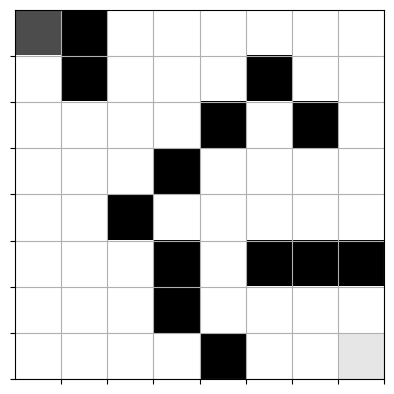

In [12]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model using the <b>build_model</b> function and train it using deep Q-learning. Note: This step takes several minutes to fully run.



<div class="alert alert-block alert-danger" style="color: #333333;">
  <b>WARNING</b>  If you did not attempt the assignment, the code <b>will</b> error out at this section.
 </div>

In [13]:
model = build_model(maze)
qtrain(model, maze, n_epoch=500, max_memory=8*maze.size, data_size=32, target_update_freq=50)

/home/codio/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch: 000/499 | Loss: 0.0012 | Episodes: 1 | Win count: 0 | Win rate: 0.000 | time: 2.8 seconds
Epoch: 001/499 | Loss: 0.0009 | Episodes: 2 | Win count: 0 | Win rate: 0.000 | time: 4.6 seconds
Epoch: 002/499 | Loss: 0.0022 | Episodes: 3 | Win count: 0 | Win rate: 0.000 | time: 6.4 seconds
Epoch: 003/499 | Loss: 0.0001 | Episodes: 4 | Win count: 0 | Win rate: 0.000 | time: 8.2 seconds
Epoch: 004/499 | Loss: 0.0008 | Episodes: 5 | Win count: 0 | Win rate: 0.000 | time: 10.1 seconds
Epoch: 005/499 | Loss: 0.0015 | Episodes: 6 | Win count: 0 | Win rate: 0.000 | time: 11.9 seconds
Epoch: 006/499 | Loss: 0.0010 | Episodes: 7 | Win count: 1 | Win rate: 0.000 | time: 12.0 seconds
Epoch: 007/499 | Loss: 0.0016 | Episodes: 8 | Win count: 2 | Win rate: 0.000 | time: 13.9 seconds
Epoch: 008/499 | Loss: 0.0014 | Episodes: 9 | Win count: 3 | Win rate: 0.000 | time: 14.6 seconds
Epoch: 009/499 | Loss: 0.0011 | Episodes: 10 | Win count: 4 | Win rate: 0.000 | time: 16.4 seconds
Epoch: 010/499 | Loss: 

<div class="alert alert-block alert-warning" style="color:black;">
<b>Note: </b> This cell will check to see if the model passes the completion check. Note: This could take several minutes.
</div>

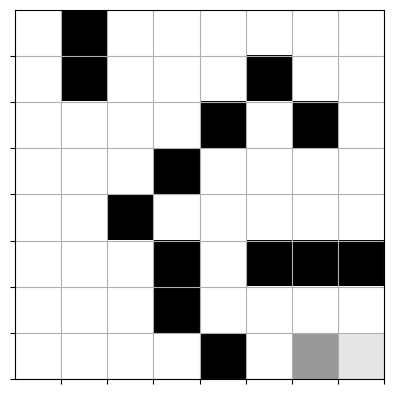

In [14]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run <b>play_game()</b>. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

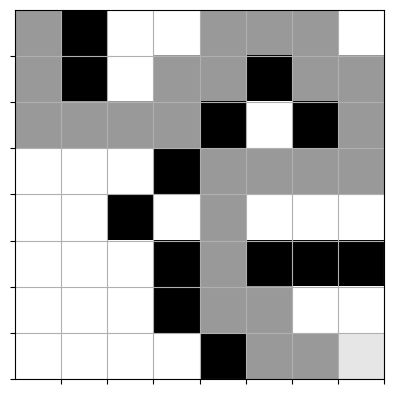

In [15]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work

<div class="alert alert-block alert-info" style="color:black;">
    <b>Hint:</b> To use the markdown block below, double click in the <b>Type Markdown and LaTeX:  𝛼2</b> block below, to turn it back to html, Run the cell.
</div>

After you have finished creating the code for your notebook, save your work.
Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.html). Download this file as an .html file clicking on ***file*** in *Jupyter Notebook*, navigating down to ***Download as*** and clicking on ***.html***. 
Download a copy of your .html file and submit it to Brightspace.